**План действий**
1. Применить маску к фотографиям \(убрать море, чтобы сеть быстрее обучалась\)
2. Использовать полноразмерные изображения \(выше точность\(?\)
3. SIFT / ROOTSIFT для извлечения точек
4. FAISS для сопоставления точек
5. Применить метод Keypoint Matching

![image](researchings/img.png 'Title')

Импорт библиотек

In [1]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import cv2
print('Библиотеки успешно загружены')

Библиотеки успешно загружены


Загрузить дата-сет

In [2]:
# dataset = keras.utils.image_dataset_from_directory('Whale ReId 2_mm', labels='inferred', shuffle='False', batch_size=64, interpolation='mitchellcubic',color_mode='rgb')
# masks = keras.utils.image_dataset_from_directory('Whale ReId 2_mm masked', labels='inferred', shuffle='False', batch_size=64, color_mode='grayscale')

train_ds, val_ds = keras.utils.image_dataset_from_directory('Whale ReId 2_mm', labels='inferred', validation_split=0.2, subset='both', seed=1337, batch_size=128, interpolation='mitchellcubic', color_mode='rgb', image_size=(256, 256))

Found 33644 files belonging to 102 classes.
Using 26916 files for training.
Using 6728 files for validation.


Вывод

In [12]:
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
    ]
)

In [13]:
def show_img(ds):
    plt.figure(figsize=(10, 10))
    for images, _ in ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype('uint8'))
            plt.axis('off')

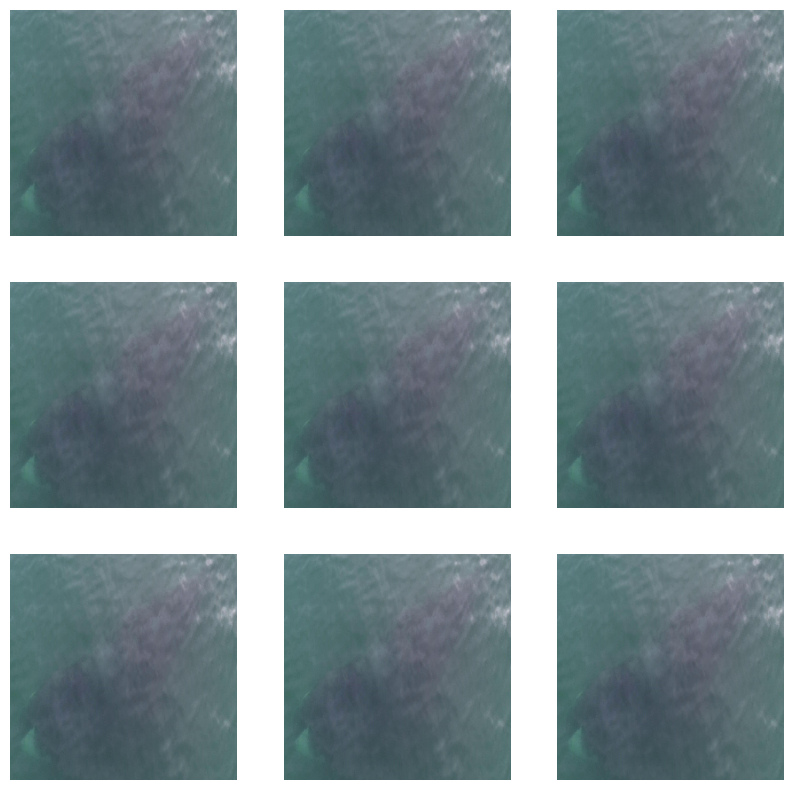

In [14]:
show_img(train_ds)

In [15]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2



In [17]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [28]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Входной блок
    x = layers.Rescaling(1. / 255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)


        residual = layers.Conv2D(1024, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.GlobalAveragePooling2D()(x)

        activation = 'softmax'

        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(102, activation=activation)(x)
        return keras.Model(inputs, outputs)

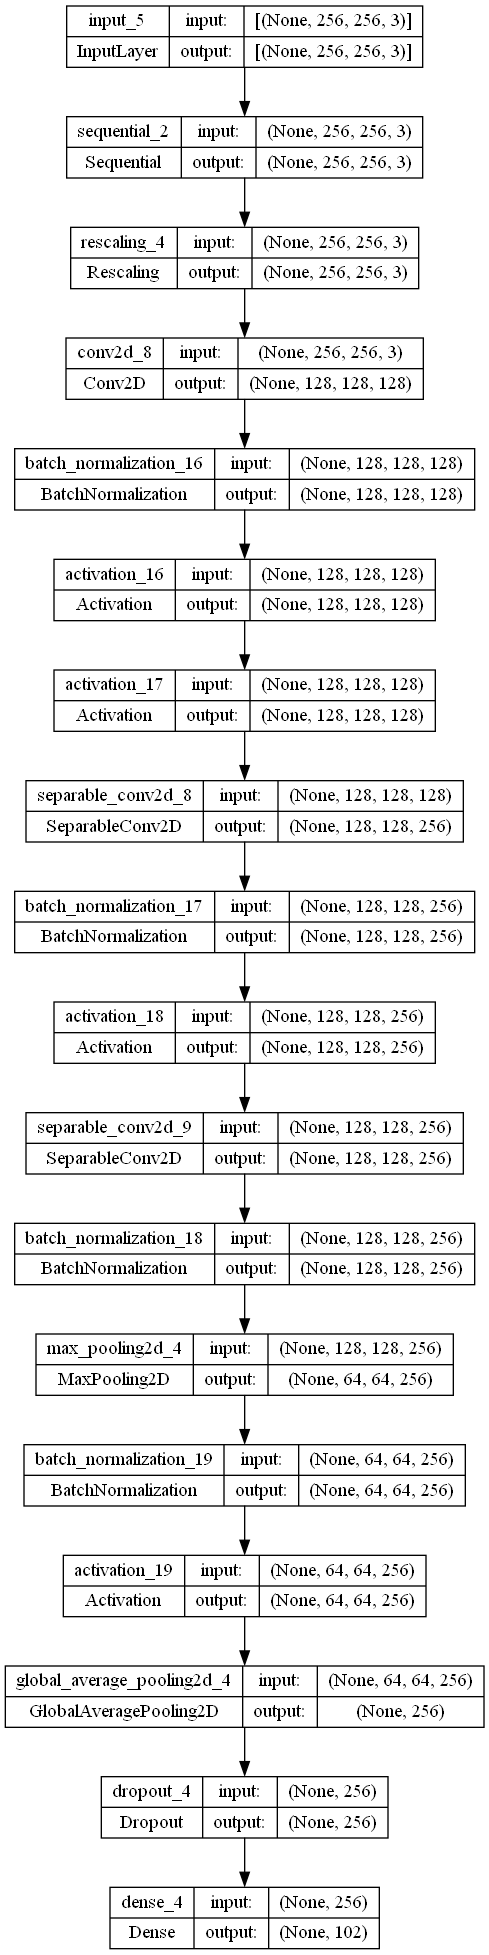

In [29]:
model = make_model(input_shape=(256, 256) + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [30]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras'),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


ValueError: in user code:

    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\slashfast\Documents\bowhead_whale\venv\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 102) vs (None, 1)).
